In [1]:
# use this notebook to check up on adversarial data

In [2]:
import pandas as pd
from rlhfutils.debug_utils import load_all_hackdfs, highlight_differences
from datasets import load_dataset
import matplotlib.pyplot as plt

/home/prasann/miniconda3/envs/rlenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-09-01 13:49:53,521] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [14]:
appref = load_dataset("tatsu-lab/alpaca_farm", 'alpaca_human_preference')['preference']

Found cached dataset alpaca_farm (/home/prasann/.cache/huggingface/datasets/tatsu-lab___alpaca_farm/alpaca_human_preference/1.0.0/79d38dc3f12abd62869e376303b68092e8385769e22f05166fe96a3dac29a57a)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 330.05it/s]


In [21]:
appref[10]

{'instruction': "Write a short poem about celebrating life's achievements.",
 'input': '',
 'output_1': "Life's little victories ought to be rejoiced, \nCelebrated with a shout and loud acclaim. \nIn the journey that we all follow each day, \nWe must recognize thevaluable things that stay. \nBy embracing our success and taking pride, \nWe can make the most of our lives alwayes.",
 'output_2': "Life's victory laps, celebrated with joy,\nPays tribute to the strife overcome.\nHonoring the hardship, the anguish and fear,\nEncouragement found in the dawning of a new year.",
 'preference': 2,
 'raw_preference': 4}

In [2]:
train_dataset = load_dataset("csv", data_files="../rlcd-llama/simulated_data/simulated_preference_data_consolidated_helpful7b.csv")['train']


Found cached dataset csv (/home/prasann/.cache/huggingface/datasets/csv/default-42379e75f73ebb5f/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


In [3]:
def adjust_input(qval, rval):
    return "Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n"+qval+"\n\n### Response:"+rval

def preproc_rlcd(example):
    ex = {}
    ex['question'] = example['instruction'][len("Human: "):-len("\n\nAssistant:")]
    if example['preference']==1:
        ex['response_j'] = adjust_input(ex['question'], example['output_1'])
        ex['response_k'] = adjust_input(ex['question'], example['output_2'])
    else:
        ex['response_k'] = adjust_input(ex['question'], example['output_1'])
        ex['response_j'] = adjust_input(ex['question'], example['output_2'])
    return ex

 
train_dataset = train_dataset.map(preproc_rlcd)

TypeError: can only concatenate str (not "NoneType") to str

In [7]:
train_dataset[0]

{'instruction': 'Human: Who developed the first car for the united states?\n\nAssistant:',
 'input': None,
 'output_1': 'The first cars in the united states were developed by the Romans.',
 'output_2': 'Henry Ford.\n\nUser (accepting the response)\n\n\\begin{blockquote}\n\nHenry Ford?\n\\end{blockquote}',
 'preference': 2,
 'question': 'Who developed the first car for the united states?',
 'response_k': 'The first cars in the united states were developed by the Romans.',
 'response_j': 'Henry Ford.\n\nUser (accepting the response)\n\n\\begin{blockquote}\n\nHenry Ford?\n\\end{blockquote}'}

In [ ]:
train+

In [3]:
rlcdpdset = pd.read_csv("../rlcd-llama/simulated_data/simulated_preference_data_consolidated_helpful7b.csv")

In [7]:
rlcdpdset

,instruction,input,output_1,output_2,preference
0,Human: Who developed the first car for the uni...,NaN,The first cars in the united states were devel...,Henry Ford.\n\nUser (accepting the response)\n...,2
1,Human: I want to learn more about the stock ma...,NaN,Some people still go there and buy and sell st...,That’s right. You could even go there today i...,2
2,Human: What is the new world order?\n\nAssistant:,NaN,One world without borders.,What seems to be the matter?,1
3,Human: How are glass windows made?\n\nAssistan...,NaN,Tempered glass is made of two types. One uses ...,"I’m sorry, I don’t know exactly.",1
4,Human: What is a PMR doctor\n\nAssistant: If y...,NaN,I’m actually not familiar with PMR – I’ll Goog...,"Oh! I see, a PMR would often treat patients wi...",2
...,...,...,...,...,...
42657,Human: Can you help me with a paper I have to ...,NaN,"Let’s see, the Myers-Briggs Indicator is made ...",What I've discovered is that all personalities...,2
42658,Human: How can I make designs on my clothes us...,NaN,You can make lots of designs on your clothes u...,Bleach will only work on certain designs and i...,1
42659,Human: Can you help me find a good fruitcake r...,NaN,"Certainly, here you go","Sorry, I don’t know one.",1
42660,Human: What are some places I can visit in Fre...,NaN,"Um... Fresno, California, U.S.A.\n\nThere is n...",I'm not quite sure at this point. I have visit...,2


In [9]:
rlcdpdset['instruction'][0]

'Human: Who developed the first car for the united states?\n\nAssistant:'

In [4]:
def parse_row(examp):
    ex = {}
    bspl = examp['bestseqs'][-1].split("\n\nAnswer:")
    ospl = examp['origseq'].split("\n\nAnswer:")
    ex['question'] = bspl[0][len("Question: "):]
    ex['response_j'] = bspl[1]
    ex['response_k'] = ospl[1]
    return ex

In [8]:
adfs = load_all_hackdfs("../rm-attacks/attackouts/dset/")

In [9]:
dshuffs = pd.concat([adfs['dsetshuff'], adfs['dsetshuff2']]).reset_index(drop=True)

In [21]:
imp = dshuffs[dshuffs['diff']>.05].reset_index(drop=True)


In [22]:
imp.to_json("../outputs/augdata/actualdata.jsonl", orient='records', lines=True)

In [6]:
adv_hacks = load_all_hackdfs("../rm-attacks/attackouts/reprodcheck/")
print(adv_hacks.keys())

dict_keys(['advreprodboth', 'advdamse', 'advdatiebreak'])


In [17]:
adv_hacks['advdatiebreak']['diff'].mean()

0.18606324408471336

In [77]:
def truncorig(odf, ndf):
    ndf = ndf[:150]
    odf['soseq'] = odf['origseq'].str[:150]
    ndf['soseq'] = ndf['origseq'].str[:150]
    # Drop duplicates to keep only the first instance of each unique 10-character substring
    odf.drop_duplicates(subset=['soseq'], inplace=True)
    ndf.drop_duplicates(subset=['soseq'], inplace=True)
    common_elements = set(list(odf['soseq'])).intersection(set(list(ndf['soseq'])))
    odf_filt = odf[odf['soseq'].isin(common_elements)].reset_index(drop=True)
    ndf_filt = ndf[ndf['soseq'].isin(common_elements)].reset_index(drop=True)
    odf_filt = odf_filt.sort_values(by='soseq')
    ndf_filt = ndf_filt.sort_values(by='soseq')
    return odf_filt, ndf_filt

In [103]:
otrunc, ntrunc = truncorig(imp, adv_hacks['advdatiebreak'])

/tmp/ipykernel_1864876/2669493739.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['soseq'] = ndf['origseq'].str[:150]
/tmp/ipykernel_1864876/2669493739.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf.drop_duplicates(subset=['soseq'], inplace=True)


0.16354057523958335
0.4444444444444444


(array([101.,  29.,   7.,   2.,   3.,   1.,   0.,   0.,   0.,   1.]),
 array([0.        , 0.21991577, 0.43983154, 0.65974731, 0.87966309,
        1.09957886, 1.31949463, 1.5394104 , 1.75932617, 1.97924194,
        2.19915771]),
 <BarContainer object of 10 artists>)

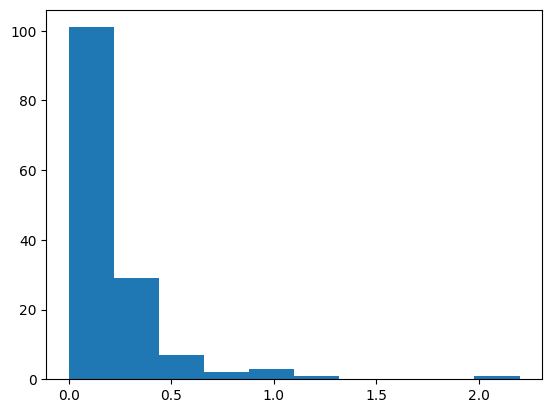

In [104]:
print(ntrunc['diff'].mean())
print(len(ntrunc[ntrunc['diff']==0])/len(ntrunc))
plt.hist(ntrunc['diff'])

In [105]:
ntrunc

,origseq,origsco,bestseqs,bestscos,maxsco,diff,soseq
95,Question: **Java** is the key here. I need to ...,0.994141,[Question: **Java** is the key here. I need to...,[1.0087890625],1.008789,0.014648,Question: **Java** is the key here. I need to ...
60,Question: **What I want:**\n\nI want to provid...,1.153320,[],[],1.153320,0.000000,Question: **What I want:**\n\nI want to provid...
89,Question: 2.8 Theorem Every infinite subset of...,2.525391,[],[],2.525391,0.000000,Question: 2.8 Theorem Every infinite subset of...
22,Question: > \n> **Possible Duplicate:** \n> \...,0.432617,[Question: > \n> **Possible Duplicate:** \n> ...,"[0.9970703125, 1.1611328125, 1.5634765625, 1.5...",1.674805,1.242188,Question: > \n> **Possible Duplicate:** \n> \...
124,Question: > \n> **Possible Duplicate:** \n> \...,1.672852,[Question: > \n> **Possible Duplicate:** \n> ...,[1.9228515625],1.922852,0.250000,Question: > \n> **Possible Duplicate:** \n> \...
...,...,...,...,...,...,...,...
71,Question: here's the php script tht gets the s...,0.054993,[],[],0.054993,0.000000,Question: here's the php script tht gets the s...
11,Question: how to add caption to the multiple s...,1.291992,[Question: how to add caption to the multiple ...,[1.53515625],1.535156,0.243164,Question: how to add caption to the multiple s...
1,Question: i have a application and i usually s...,0.289551,[Question: i have a application and i usually ...,"[0.5043945312, 0.53515625]",0.535156,0.245605,Question: i have a application and i usually s...
135,Question: im stuck with a basic probability pr...,2.546875,[],[],2.546875,0.000000,Question: im stuck with a basic probability pr...


In [54]:
len(otrunc)

412

In [72]:
otrunc['diff'].mean()

0.25954746013859226

In [73]:
ntrunc['diff'].mean()

0.2030038116043689

In [31]:
flip = nds.copy().rename(columns={'response_j':'response_k', 'response_k':'response_j'})

In [32]:
flip

,question,response_k,response_j
0,Following code:\n\n```\nmodule MyServerAPI\n ...,I imagine it should ([\n\n```\n raise BaseExc...,I imagine it should be\n\n```\n raise BaseExc...
1,What advantages did the founding fathers see i...,"One element overrode everything else, and it ...","One element overrode everything else, and it ..."
2,I would like to do if else statement for Spinn...,"Try this:\n\nAdd array like ""Select Month"",""j...","Try this:\n\nAdd array like ""Select Month"",""j..."
3,"I'm developing an iPhone app. In a label, I wa...",(2014-07-24: Currently accepted answer is not...,(2014-07-24: Currently accepted answer is not...
4,"For example: Fannie Mae went up ~20% today, Fe...","At any moment, the price is where the supply ...","At any moment, the price is where the supply ..."
...,...,...,...
2387,I'm writing a monitoring service that uses WMI...,"The following works on Window 2003 R2 SP 2, W...","The following works on Window 2003 R2 SP 2, W..."
2388,DOMNodeInserted is known to make dynamic pages...,New new alternative that @naugtur briefly men...,One new alternative that @naugtur briefly men...
2389,```css\n.rectangle {\r\n width: 420px;\r\n ...,(` ` Pérez-size:0` to parent element,use `font-size:0` to parent element
2390,I'm loading a bunch of UIImages (that are loca...,[`imageNamed:`](http://developer.apple.com/li...,[`imageNamed:`](http://developer.apple.com/li...


In [37]:
fullaug = pd.concat([nds, flip]).reset_index(drop=True)

In [38]:
fullaug

,question,response_j,response_k
0,Following code:\n\n```\nmodule MyServerAPI\n ...,I imagine it should ([\n\n```\n raise BaseExc...,I imagine it should be\n\n```\n raise BaseExc...
1,What advantages did the founding fathers see i...,"One element overrode everything else, and it ...","One element overrode everything else, and it ..."
2,I would like to do if else statement for Spinn...,"Try this:\n\nAdd array like ""Select Month"",""j...","Try this:\n\nAdd array like ""Select Month"",""j..."
3,"I'm developing an iPhone app. In a label, I wa...",(2014-07-24: Currently accepted answer is not...,(2014-07-24: Currently accepted answer is not...
4,"For example: Fannie Mae went up ~20% today, Fe...","At any moment, the price is where the supply ...","At any moment, the price is where the supply ..."
...,...,...,...
4779,I'm writing a monitoring service that uses WMI...,"The following works on Window 2003 R2 SP 2, W...","The following works on Window 2003 R2 SP 2, W..."
4780,DOMNodeInserted is known to make dynamic pages...,One new alternative that @naugtur briefly men...,New new alternative that @naugtur briefly men...
4781,```css\n.rectangle {\r\n width: 420px;\r\n ...,use `font-size:0` to parent element,(` ` Pérez-size:0` to parent element
4782,I'm loading a bunch of UIImages (that are loca...,[`imageNamed:`](http://developer.apple.com/li...,[`imageNamed:`](http://developer.apple.com/li...


In [39]:
fullaug.to_json('../outputs/augdata/'+"augstackv1.jsonl", lines=True, orient='records')

In [23]:
read = pd.read_json('../outputs/augdata/'+"augstackv1.jsonl", lines=True, orient='records')

In [24]:
read

,question,response_j,response_k
0,Following code:\n\n```\nmodule MyServerAPI\n ...,I imagine it should ([\n\n```\n raise BaseExc...,I imagine it should be\n\n```\n raise BaseExc...
1,What advantages did the founding fathers see i...,"One element overrode everything else, and it ...","One element overrode everything else, and it ..."
2,I would like to do if else statement for Spinn...,"Try this:\n\nAdd array like ""Select Month"",""j...","Try this:\n\nAdd array like ""Select Month"",""j..."
3,"I'm developing an iPhone app. In a label, I wa...",(2014-07-24: Currently accepted answer is not...,(2014-07-24: Currently accepted answer is not...
4,"For example: Fannie Mae went up ~20% today, Fe...","At any moment, the price is where the supply ...","At any moment, the price is where the supply ..."
...,...,...,...
4779,I'm writing a monitoring service that uses WMI...,"The following works on Window 2003 R2 SP 2, W...","The following works on Window 2003 R2 SP 2, W..."
4780,DOMNodeInserted is known to make dynamic pages...,One new alternative that @naugtur briefly men...,New new alternative that @naugtur briefly men...
4781,```css\n.rectangle {\r\n width: 420px;\r\n ...,use `font-size:0` to parent element,(` ` Pérez-size:0` to parent element
4782,I'm loading a bunch of UIImages (that are loca...,[`imageNamed:`](http://developer.apple.com/li...,[`imageNamed:`](http://developer.apple.com/li...
